In [2]:
import sys
import tensorflow as tf
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

from pathlib import Path


2023-11-28 12:45:01.599781: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-28 12:45:01.687961: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


# Basic RNNs

Let's download the ridership data from the ageron/data project. It originally comes from Chicago's Transit Authority, and was downloaded from the [Chicago's Data Portal](https://homl.info/ridership).

In [3]:
tf.keras.utils.get_file(
    "ridership.tgz",
    "https://github.com/ageron/data/raw/main/ridership.tgz",
    cache_dir="./data",
    extract=True
)

'./data/datasets/ridership.tgz'

In [4]:
import pandas as pd

path = Path("./data/datasets/ridership/CTA_-_Ridership_-_Daily_Boarding_Totals.csv")
df = pd.read_csv(path, parse_dates=["service_date"])
df.columns = ["date", "day_type", "bus", "rail", "total"]  # shorter names
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1)  # no need for total, it's just bus + rail
df = df.drop_duplicates()  # remove duplicated months (2011-10 and 2014-07)

In [4]:
df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


Let's look at the first few months of 2019 (note that Pandas treats the range boundaries as inclusive):

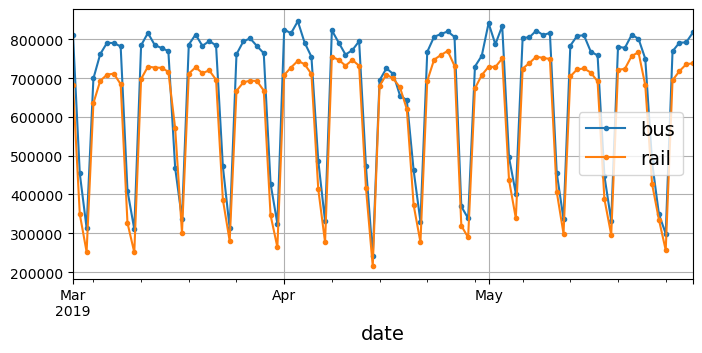

In [5]:
import matplotlib.pyplot as plt

df["2019-03":"2019-05"].plot(grid=True, marker=".", figsize=(8, 3.5))
plt.show()

**Naive forecasting**

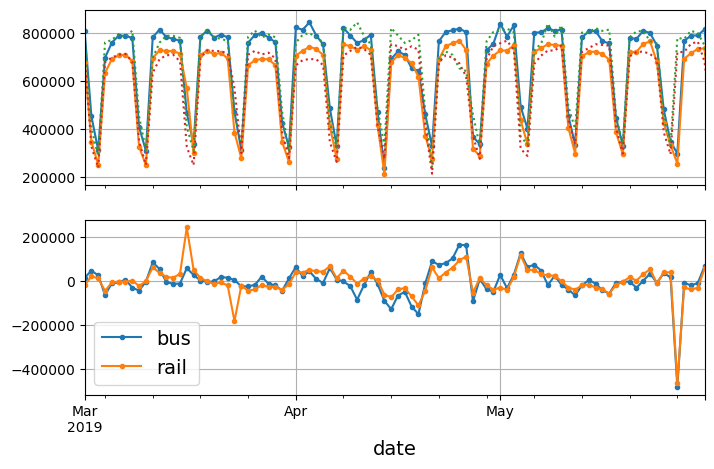

In [6]:
diff_7 = df[["bus", "rail"]].diff(7)["2019-03":"2019-05"]

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 5))
df.plot(ax=axs[0], legend=False, marker=".")  # original time series
df.shift(7).plot(ax=axs[0], grid=True, legend=False, linestyle=":")  # lagged
diff_7.plot(ax=axs[1], grid=True, marker=".")  # 7-day difference time series
axs[0].set_ylim([170_000, 900_000])  # extra code – beautifies the plot
plt.show()

Mean absolute error (MAE), also called mean absolute deviation (MAD):

In [7]:
diff_7.abs().mean()

bus     43915.608696
rail    42143.271739
dtype: float64

Mean absolute percentage error (MAPE):

In [22]:
targets = df[["bus", "rail"]]["2019-03":"2019-05"]
(diff_7 / targets).abs().mean()*100

bus     8.293847
rail    8.994765
dtype: float64

Now let's look at the yearly seasonality and the long-term trends:

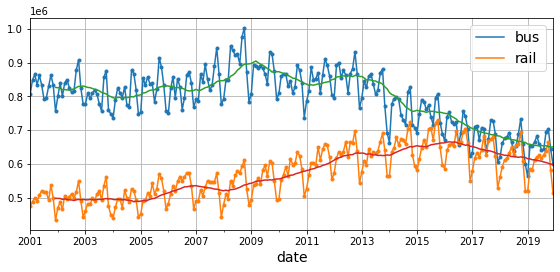

In [14]:
period = slice("2001", "2019")
df_monthly = df.resample('M').mean()  # compute the mean for each month
rolling_average_12_months = df_monthly[period].rolling(window=12).mean()

fig, ax = plt.subplots(figsize=(8, 4))
df_monthly[period].plot(ax=ax, marker=".")
rolling_average_12_months.plot(ax=ax, grid=True, legend=False)
plt.show()

To use ARIMA, we need the `statsmodels` library. Use `conda install...` to install it.
If running on Colab or Kaggle, install the statsmodels library immediately:

In [13]:
if "google.colab" in sys.modules:
    %pip install -q -U statsmodels

In [8]:
from statsmodels.tsa.arima.model import ARIMA

origin, start_date, end_date = "2019-01-01", "2019-03-01", "2019-05-31"
time_period = pd.date_range(start_date, end_date)
rail_series = df.loc[origin:end_date]["rail"].asfreq("D")
y_preds = []
for today in time_period.shift(-1):
    model = ARIMA(rail_series[origin:today],  # train on data up to "today"
                  order=(1, 0, 0),
                  seasonal_order=(0, 1, 1, 7))
    model = model.fit()  # note that we retrain the model every day!
    y_pred = model.forecast()[0]
    y_preds.append(y_pred)

y_preds = pd.Series(y_preds, index=time_period)
mae = (y_preds - rail_series[time_period]).abs().mean()  

mape = ((y_preds - rail_series[time_period])/rail_series[time_period]).abs().mean()*100

In [20]:
mae

32040.720101139206

In [21]:
mape

7.543100730010598

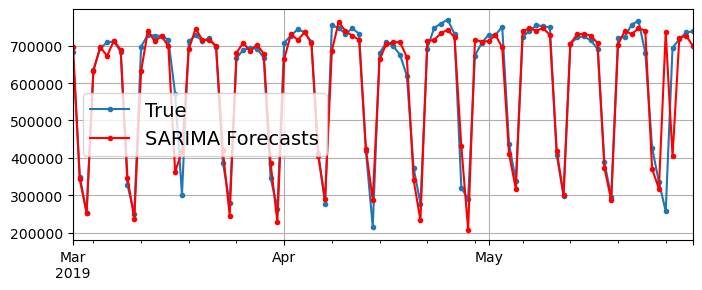

In [11]:
# extra code – displays the SARIMA forecasts
fig, ax = plt.subplots(figsize=(8, 3))
rail_series.loc[time_period].plot(label="True", ax=ax, marker=".", grid=True)
ax.plot(y_preds, color="r", marker=".", label="SARIMA Forecasts")
plt.legend()
plt.show()

## Preparing Data for Machine Learning Models

In [9]:
# TOY EXAMPLE of windowing
raw_dataset = tf.data.Dataset.range(6)
for element in raw_dataset:
    print(element)

dataset = raw_dataset.window(4, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window_dataset: window_dataset.batch(4))
for window_tensor in dataset:
    print(f"{window_tensor}")

tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(5, shape=(), dtype=int64)
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
[0 1 2 3]
[1 2 3 4]
[2 3 4 5]


2023-11-28 12:54:58.326697: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
def to_windows(dataset, length):
    dataset = dataset.window(length, shift=1, drop_remainder=True)
    return dataset.flat_map(lambda window_ds: window_ds.batch(length))

Before we continue looking at the data, let's split the time series into three periods, for training, validation and testing. We won't look at the test data for now:

In [10]:
rail_train = df["rail"]["2016-01":"2018-12"] / 1e6
rail_valid = df["rail"]["2019-01":"2019-05"] / 1e6
rail_test = df["rail"]["2019-06":] / 1e6

In [11]:
seq_length = 56 # 8 weeks
tf.random.set_seed(42)  # extra code – ensures reproducibility
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets=rail_train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets=rail_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

## Using a Simple RNN

In [12]:
# a utility function we'll reuse several time
def fit_and_evaluate(model, train_set, 
                     valid_set, epochs=500, opt="adam", eval=True):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=50, restore_best_weights=True)
    
    
    
    model.compile(loss=tf.keras.losses.Huber(), 
                  optimizer=opt, metrics=["mae", "mape"])
    
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs,
                        callbacks=[early_stopping_cb])
    if eval:
        valid_loss, valid_mae, valid_mape = model.evaluate(valid_set)
        return valid_mape

In [13]:
tf.random.set_seed(42) 
univar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 1]), # None: sequences of any length
    tf.keras.layers.Dense(1)  # no activation function by default
])

In [14]:
fit_and_evaluate(univar_model, train_ds, valid_ds, opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9))

Epoch 1/500
33/33 [==============================] - 1s 8ms/step - loss: 0.0393 - mae: 0.1983 - mape: 40.3131 - val_loss: 0.0179 - val_mae: 0.1250 - val_mape: 35.3375
Epoch 2/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0120 - mae: 0.1231 - mape: 26.1663 - val_loss: 0.0060 - val_mae: 0.0906 - val_mape: 19.8221
Epoch 3/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0072 - mae: 0.0944 - mape: 18.8664 - val_loss: 0.0048 - val_mae: 0.0720 - val_mape: 13.7309
Epoch 4/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0053 - mae: 0.0767 - mape: 15.6598 - val_loss: 0.0034 - val_mae: 0.0674 - val_mape: 14.4737
Epoch 5/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0038 - mae: 0.0618 - mape: 12.8001 - val_loss: 0.0030 - val_mae: 0.0575 - val_mape: 13.0166
Epoch 6/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0035 - mae: 0.0564 - mape: 11.8910 - val_loss: 0.0027 - val_mae: 0.0549 - val_mape: 12.249

6.873440265655518

## Deep RNN (a bit too complex for this example though)

In [23]:
tf.random.set_seed(42)  
deep_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])
# return_sequences=True is necessary otherwise the RNN layer returns an output only at the last time step

In [45]:
fit_and_evaluate(deep_model, train_ds, valid_ds)

Epoch 1/500
33/33 [==============================] - 2s 17ms/step - loss: 0.0062 - mae: 0.0810 - mape: 15.6848 - val_loss: 0.0029 - val_mae: 0.0515 - val_mape: 11.1529
Epoch 2/500
33/33 [==============================] - 0s 13ms/step - loss: 0.0027 - mae: 0.0468 - mape: 9.7284 - val_loss: 0.0018 - val_mae: 0.0315 - val_mape: 7.0229
Epoch 3/500
33/33 [==============================] - 0s 13ms/step - loss: 0.0024 - mae: 0.0414 - mape: 8.7804 - val_loss: 0.0019 - val_mae: 0.0362 - val_mape: 8.1108
Epoch 4/500
33/33 [==============================] - 0s 13ms/step - loss: 0.0028 - mae: 0.0480 - mape: 9.8300 - val_loss: 0.0019 - val_mae: 0.0348 - val_mape: 8.0041
Epoch 5/500
33/33 [==============================] - 0s 12ms/step - loss: 0.0034 - mae: 0.0558 - mape: 11.3715 - val_loss: 0.0021 - val_mae: 0.0408 - val_mape: 8.5300
Epoch 6/500
33/33 [==============================] - 0s 12ms/step - loss: 0.0027 - mae: 0.0478 - mape: 9.7974 - val_loss: 0.0025 - val_mae: 0.0448 - val_mape: 9.5180
E

7.022852897644043

## Multivariate time series

In [25]:
df_mulvar = df[["bus", "rail"]] / 1e6  # use both bus & rail series as input
df_mulvar["next_day_type"] = df["day_type"].shift(-1)  # we know tomorrow's type (no need to predict!)
df_mulvar = pd.get_dummies(df_mulvar, dtype=float)  # one-hot encode the day type
df_mulvar.head()

,bus,rail,next_day_type_A,next_day_type_U,next_day_type_W
date,,,,,
2001-01-01,0.297192,0.126455,0.0,0.0,1.0
2001-01-02,0.780827,0.501952,0.0,0.0,1.0
2001-01-03,0.824923,0.536432,0.0,0.0,1.0
2001-01-04,0.870021,0.550011,0.0,0.0,1.0
2001-01-05,0.890426,0.557917,1.0,0.0,0.0


In [26]:
mulvar_train = df_mulvar["2016-01":"2018-12"]
mulvar_valid = df_mulvar["2019-01":"2019-05"]
mulvar_test = df_mulvar["2019-06":]

In [27]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
mulvar_train.head()

train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),  # use all 5 columns as input
    targets=mulvar_train["rail"][seq_length:],  # forecast only the rail series
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=mulvar_valid["rail"][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

In [28]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
mulvar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(1)
])

In [46]:
# extra code – compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(mulvar_model, train_mulvar_ds, valid_mulvar_ds)

Epoch 1/500
33/33 [==============================] - 1s 7ms/step - loss: 0.0012 - mae: 0.0341 - mape: 6.4259 - val_loss: 9.0424e-04 - val_mae: 0.0333 - val_mape: 6.5630
Epoch 2/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0010 - mae: 0.0308 - mape: 5.8369 - val_loss: 6.8583e-04 - val_mae: 0.0258 - val_mape: 5.6245
Epoch 3/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0010 - mae: 0.0310 - mape: 5.8686 - val_loss: 8.1322e-04 - val_mae: 0.0290 - val_mape: 6.5300
Epoch 4/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0011 - mae: 0.0312 - mape: 5.9537 - val_loss: 8.5556e-04 - val_mae: 0.0307 - val_mape: 6.5121
Epoch 5/500
33/33 [==============================] - 0s 5ms/step - loss: 9.9005e-04 - mae: 0.0303 - mape: 5.7062 - val_loss: 0.0011 - val_mae: 0.0362 - val_mape: 7.6971
Epoch 6/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0011 - mae: 0.0322 - mape: 6.0531 - val_loss: 8.0144e-04 - val_mae: 0.0275 - val

4.971500873565674

In [47]:
# extra code – build and train a multitask RNN that forecasts both bus and rail

tf.random.set_seed(42)

seq_length = 56
train_multask_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=mulvar_train[["bus", "rail"]][seq_length:],  # 2 targets per day
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_multask_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=mulvar_valid[["bus", "rail"]][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

tf.random.set_seed(42)
multask_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(2)
])


fit_and_evaluate(multask_model, train_multask_ds, valid_multask_ds)

Epoch 1/500
33/33 [==============================] - 1s 8ms/step - loss: 0.0379 - mae: 0.2019 - mape: 35.4072 - val_loss: 0.0045 - val_mae: 0.0808 - val_mape: 14.8217
Epoch 2/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0058 - mae: 0.0817 - mape: 14.8733 - val_loss: 0.0027 - val_mae: 0.0579 - val_mape: 11.1026
Epoch 3/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0039 - mae: 0.0636 - mape: 11.7510 - val_loss: 0.0016 - val_mae: 0.0441 - val_mape: 8.4019
Epoch 4/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0034 - mae: 0.0592 - mape: 10.7947 - val_loss: 0.0024 - val_mae: 0.0546 - val_mape: 11.0889
Epoch 5/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0030 - mae: 0.0548 - mape: 10.2366 - val_loss: 0.0014 - val_mae: 0.0406 - val_mape: 8.1401
Epoch 6/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0027 - mae: 0.0518 - mape: 9.6048 - val_loss: 0.0015 - val_mae: 0.0435 - val_mape: 8.7292
Ep

4.932424545288086

In [34]:
# extra code – evaluates the naive forecasts for bus
bus_naive = mulvar_valid["bus"].shift(7)[seq_length:]
bus_target = mulvar_valid["bus"][seq_length:]
((bus_target - bus_naive)/bus_target).abs().mean()*100

8.148701672585455

In [48]:
# extra code – evaluates the multitask RNN's forecasts both bus and rail
Y_preds_valid = multask_model.predict(valid_multask_ds)
for idx, name in enumerate(["bus", "rail"]):
    mape = tf.keras.metrics.mean_absolute_percentage_error(
        mulvar_valid[name][seq_length:], Y_preds_valid[:, idx])
    print(name, float(mape))

3/3 [==============================] - 0s 2ms/step
bus 4.723814964294434
rail 5.141034126281738


In [49]:
deep_multask_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(2)
])
fit_and_evaluate(deep_multask_model, train_multask_ds, valid_multask_ds)

Epoch 1/500
33/33 [==============================] - 2s 17ms/step - loss: 0.1016 - mae: 0.2994 - mape: 51.0816 - val_loss: 0.0063 - val_mae: 0.0826 - val_mape: 15.6928
Epoch 2/500
33/33 [==============================] - 0s 12ms/step - loss: 0.0071 - mae: 0.0814 - mape: 14.9440 - val_loss: 0.0031 - val_mae: 0.0555 - val_mape: 10.9765
Epoch 3/500
33/33 [==============================] - 0s 12ms/step - loss: 0.0048 - mae: 0.0654 - mape: 12.2414 - val_loss: 0.0023 - val_mae: 0.0456 - val_mape: 9.4048
Epoch 4/500
33/33 [==============================] - 0s 13ms/step - loss: 0.0041 - mae: 0.0606 - mape: 11.4482 - val_loss: 0.0025 - val_mae: 0.0508 - val_mape: 10.3579
Epoch 5/500
33/33 [==============================] - 0s 12ms/step - loss: 0.0037 - mae: 0.0576 - mape: 10.9843 - val_loss: 0.0015 - val_mae: 0.0362 - val_mape: 7.3177
Epoch 6/500
33/33 [==============================] - 0s 12ms/step - loss: 0.0032 - mae: 0.0527 - mape: 10.0131 - val_loss: 0.0015 - val_mae: 0.0378 - val_mape: 7.

4.807779312133789

## Forecasting Several Steps Ahead

In [54]:
import numpy as np

X = rail_valid.to_numpy()[np.newaxis, :seq_length, np.newaxis]
for step_ahead in range(14):
    y_pred_one = univar_model.predict(X)
    X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis=1)

1/1 [==============================] - 0s 12ms/step


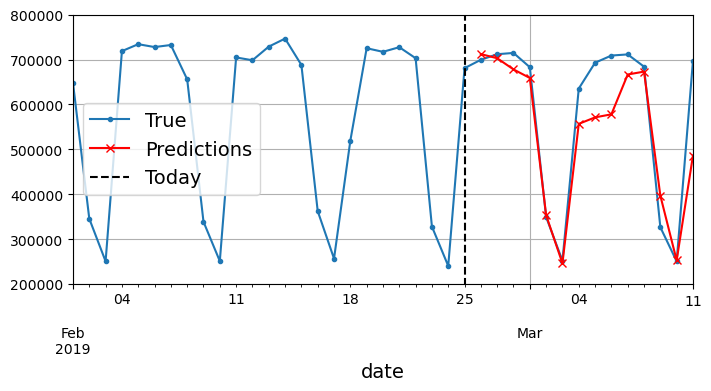

In [56]:
# extra code – generates and saves Figure 15–11

# The forecasts start on 2019-02-26, as it is the 57th day of 2019, and they end
# on 2019-03-11. That's 14 days in total.
Y_pred = pd.Series(X[0, -14:, 0],
                   index=pd.date_range("2019-02-26", "2019-03-11"))

fig, ax = plt.subplots(figsize=(8, 3.5))
(rail_valid * 1e6)["2019-02-01":"2019-03-11"].plot(
    label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(
    label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines("2019-02-25", 0, 1e6, color="k", linestyle="--", label="Today")
ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
plt.show()

Now let's create an RNN that predicts all 14 next values at once:

In [57]:
tf.random.set_seed(42)  # extra code – ensures reproducibility

def split_inputs_and_targets(mulvar_series, ahead=14, target_col=1):
    return mulvar_series[:, :-ahead], mulvar_series[:, -ahead:, target_col]

ahead_train_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32,
    shuffle=True,
    seed=42
).map(split_inputs_and_targets)
ahead_valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32
).map(split_inputs_and_targets)

In [58]:
tf.random.set_seed(42)

ahead_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

In [59]:
# extra code – compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(ahead_model, ahead_train_ds, ahead_valid_ds, eval=False)

Epoch 1/500
33/33 [==============================] - 1s 7ms/step - loss: 0.1321 - mae: 0.4111 - mape: 66.4839 - val_loss: 0.0352 - val_mae: 0.2193 - val_mape: 42.3749
Epoch 2/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0222 - mae: 0.1675 - mape: 32.4410 - val_loss: 0.0144 - val_mae: 0.1314 - val_mape: 30.5978
Epoch 3/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0135 - mae: 0.1284 - mape: 26.5364 - val_loss: 0.0108 - val_mae: 0.1129 - val_mape: 26.5498
Epoch 4/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0111 - mae: 0.1160 - mape: 23.9380 - val_loss: 0.0092 - val_mae: 0.1035 - val_mape: 24.2977
Epoch 5/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0097 - mae: 0.1068 - mape: 22.0230 - val_loss: 0.0077 - val_mae: 0.0958 - val_mape: 22.2383
Epoch 6/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0085 - mae: 0.0990 - mape: 20.4115 - val_loss: 0.0066 - val_mae: 0.0875 - val_mape: 20.184

6.99240255355835

In [83]:
Y_pred_valid = ahead_model.predict(ahead_valid_ds) # shape [1, 14]

for ahead in range(14):
    preds = pd.Series(Y_pred_valid[:-1, ahead],
                      index=mulvar_valid.index[56 + ahead : -14 + ahead])
    mae = (preds - mulvar_valid["rail"]).abs().mean() * 1e6
    mape = ((preds - mulvar_valid["rail"])/mulvar_valid["rail"]).abs().mean() * 100
    print(f"MAE for +{ahead + 1}: {mae:,.0f} (MAPE {mape:.1f})")

3/3 [==============================] - 0s 2ms/step
MAE for +1: 26,383 (6.0)
MAE for +2: 27,742 (5.2)
MAE for +3: 30,237 (6.0)
MAE for +4: 32,245 (5.8)
MAE for +5: 36,581 (6.6)
MAE for +6: 32,990 (6.5)
MAE for +7: 35,386 (7.0)
MAE for +8: 37,795 (7.5)
MAE for +9: 32,449 (6.3)
MAE for +10: 35,460 (6.7)
MAE for +11: 39,183 (8.5)
MAE for +12: 39,800 (8.5)
MAE for +13: 34,058 (7.9)
MAE for +14: 34,050 (7.9)


Now let's create an RNN that predicts the next 14 steps at each time step (**sequence-to-sequence**). 

To prepare the datasets, we can use `to_windows()` twice, to get sequences of consecutive windows, like this:

In [61]:
my_series = tf.data.Dataset.range(7)
dataset = to_windows(to_windows(my_series, 3), 4)
list(dataset)

[<tf.Tensor: shape=(4, 3), dtype=int64, numpy=
 array([[0, 1, 2],
        [1, 2, 3],
        [2, 3, 4],
        [3, 4, 5]])>,
 <tf.Tensor: shape=(4, 3), dtype=int64, numpy=
 array([[1, 2, 3],
        [2, 3, 4],
        [3, 4, 5],
        [4, 5, 6]])>]

Then we can split these elements into the desired inputs and targets:

In [62]:
dataset = dataset.map(lambda S: (S[:, 0], S[:, 1:]))
list(dataset)

[(<tf.Tensor: shape=(4,), dtype=int64, numpy=array([0, 1, 2, 3])>,
  <tf.Tensor: shape=(4, 2), dtype=int64, numpy=
  array([[1, 2],
         [2, 3],
         [3, 4],
         [4, 5]])>),
 (<tf.Tensor: shape=(4,), dtype=int64, numpy=array([1, 2, 3, 4])>,
  <tf.Tensor: shape=(4, 2), dtype=int64, numpy=
  array([[2, 3],
         [3, 4],
         [4, 5],
         [5, 6]])>)]

Let's wrap this idea into a utility function. It will also take care of shuffling (optional) and batching:

In [63]:
def to_seq2seq_dataset(series, seq_length=56, ahead=14, target_col=1,
                       batch_size=32, shuffle=False, seed=None):
    ds = to_windows(tf.data.Dataset.from_tensor_slices(series), ahead + 1)
    ds = to_windows(ds, seq_length).map(lambda S: (S[:, 0], S[:, 1:, 1]))
    if shuffle:
        ds = ds.shuffle(8 * batch_size, seed=seed)
    return ds.batch(batch_size)

In [64]:
seq2seq_train = to_seq2seq_dataset(mulvar_train, shuffle=True, seed=42)
seq2seq_valid = to_seq2seq_dataset(mulvar_valid)

In [65]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
seq2seq_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
    # equivalent: tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(14))
])

In [72]:
fit_and_evaluate(seq2seq_model, seq2seq_train, seq2seq_valid, opt = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9), eval=False)

Epoch 1/500
33/33 [==============================] - 1s 8ms/step - loss: 0.0031 - mae: 0.0467 - mape: 9.7805 - val_loss: 0.0037 - val_mae: 0.0490 - val_mape: 13.3751
Epoch 2/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0030 - mae: 0.0465 - mape: 9.7558 - val_loss: 0.0037 - val_mae: 0.0480 - val_mape: 12.8361
Epoch 3/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0030 - mae: 0.0464 - mape: 9.7377 - val_loss: 0.0037 - val_mae: 0.0480 - val_mape: 12.8617
Epoch 4/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0030 - mae: 0.0464 - mape: 9.7418 - val_loss: 0.0037 - val_mae: 0.0490 - val_mape: 12.7371
Epoch 5/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0030 - mae: 0.0465 - mape: 9.7353 - val_loss: 0.0037 - val_mae: 0.0480 - val_mape: 12.8231
Epoch 6/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0030 - mae: 0.0460 - mape: 9.6641 - val_loss: 0.0037 - val_mae: 0.0482 - val_mape: 12.9206
Epoc

12.67932415008545

In [86]:
Y_pred_valid = seq2seq_model.predict(seq2seq_valid)
for ahead in range(14):
    preds = pd.Series(Y_pred_valid[:-1, -1, ahead],
                      index=mulvar_valid.index[56 + ahead : -14 + ahead])
    mae = (preds - mulvar_valid["rail"]).abs().mean() * 1e6
    mape = ((preds - mulvar_valid["rail"])/mulvar_valid["rail"]).abs().mean() * 100
    print(f"MAE for +{ahead + 1}: {mae:,.0f} (MAPE {mape:.1f})")

3/3 [==============================] - 0s 6ms/step
MAE for +1: 25,330 (MAPE 5.3)
MAE for +2: 30,899 (MAPE 6.5)
MAE for +3: 33,521 (MAPE 6.6)
MAE for +4: 33,337 (MAPE 6.2)
MAE for +5: 32,976 (MAPE 6.3)
MAE for +6: 35,603 (MAPE 6.8)
MAE for +7: 35,673 (MAPE 7.1)
MAE for +8: 36,366 (MAPE 7.2)
MAE for +9: 33,214 (MAPE 6.6)
MAE for +10: 32,840 (MAPE 6.5)
MAE for +11: 36,638 (MAPE 8.3)
MAE for +12: 36,232 (MAPE 8.3)
MAE for +13: 36,322 (MAPE 8.3)
MAE for +14: 34,288 (MAPE 7.7)


# LSTMs

In [89]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

Just training for 5 epochs to show that it works (you can increase this if you want):

In [92]:
fit_and_evaluate(lstm_model, seq2seq_train, seq2seq_valid)

Epoch 1/500
33/33 [==============================] - 1s 16ms/step - loss: 0.0155 - mae: 0.1397 - mape: 28.7086 - val_loss: 0.0141 - val_mae: 0.1266 - val_mape: 33.7563
Epoch 2/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0115 - mae: 0.1171 - mape: 23.9628 - val_loss: 0.0105 - val_mae: 0.1098 - val_mape: 28.3121
Epoch 3/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0092 - mae: 0.1017 - mape: 20.2363 - val_loss: 0.0087 - val_mae: 0.0986 - val_mape: 25.0555
Epoch 4/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0080 - mae: 0.0934 - mape: 18.5602 - val_loss: 0.0078 - val_mae: 0.0916 - val_mape: 23.6563
Epoch 5/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0071 - mae: 0.0872 - mape: 17.4234 - val_loss: 0.0071 - val_mae: 0.0868 - val_mape: 22.6062
Epoch 6/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0065 - mae: 0.0822 - mape: 16.4777 - val_loss: 0.0065 - val_mae: 0.0813 - val_mape: 21.08

12.537454605102539

In [93]:
Y_pred_valid = lstm_model.predict(seq2seq_valid)
for ahead in range(14):
    preds = pd.Series(Y_pred_valid[:-1, -1, ahead],
                      index=mulvar_valid.index[56 + ahead : -14 + ahead])
    mae = (preds - mulvar_valid["rail"]).abs().mean() * 1e6
    mape = ((preds - mulvar_valid["rail"])/mulvar_valid["rail"]).abs().mean() * 100
    print(f"MAE for +{ahead + 1}: {mae:,.0f} (MAPE {mape:.1f})")

3/3 [==============================] - 0s 6ms/step
MAE for +1: 23,816 (MAPE 5.0)
MAE for +2: 29,488 (MAPE 5.8)
MAE for +3: 31,003 (MAPE 5.9)
MAE for +4: 32,560 (MAPE 6.3)
MAE for +5: 33,764 (MAPE 6.7)
MAE for +6: 36,060 (MAPE 7.0)
MAE for +7: 33,710 (MAPE 6.6)
MAE for +8: 34,989 (MAPE 6.7)
MAE for +9: 34,349 (MAPE 6.9)
MAE for +10: 30,473 (MAPE 6.0)
MAE for +11: 35,596 (MAPE 8.1)
MAE for +12: 37,376 (MAPE 8.7)
MAE for +13: 36,214 (MAPE 8.4)
MAE for +14: 35,398 (MAPE 8.2)


# WaveNet (simplified implementation, no residual blocks)

In [94]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
wavenet_model = tf.keras.Sequential()
wavenet_model.add(tf.keras.layers.InputLayer(input_shape=[None, 5]))
for rate in (1, 2, 4, 8) * 2:
    wavenet_model.add(tf.keras.layers.Conv1D(
        filters=32, kernel_size=2, padding="causal", activation="relu",
        dilation_rate=rate))
wavenet_model.add(tf.keras.layers.Conv1D(filters=14, kernel_size=1))

In [97]:
fit_and_evaluate(wavenet_model, seq2seq_train, seq2seq_valid)

Epoch 1/500
33/33 [==============================] - 1s 13ms/step - loss: 0.1291 - mae: 0.4421 - mape: 70.4924 - val_loss: 0.0396 - val_mae: 0.2258 - val_mape: 46.6979
Epoch 2/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0253 - mae: 0.1787 - mape: 34.1024 - val_loss: 0.0160 - val_mae: 0.1365 - val_mape: 36.1147
Epoch 3/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0128 - mae: 0.1279 - mape: 26.1486 - val_loss: 0.0121 - val_mae: 0.1181 - val_mape: 32.1310
Epoch 4/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0100 - mae: 0.1102 - mape: 22.3227 - val_loss: 0.0101 - val_mae: 0.1057 - val_mape: 28.8238
Epoch 5/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0081 - mae: 0.0955 - mape: 19.4319 - val_loss: 0.0075 - val_mae: 0.0866 - val_mape: 23.2319
Epoch 6/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0070 - mae: 0.0864 - mape: 17.5859 - val_loss: 0.0068 - val_mae: 0.0792 - val_mape: 22.04

12.500465393066406

In [98]:
Y_pred_valid = wavenet_model.predict(seq2seq_valid)
for ahead in range(14):
    preds = pd.Series(Y_pred_valid[:-1, -1, ahead],
                      index=mulvar_valid.index[56 + ahead : -14 + ahead])
    mae = (preds - mulvar_valid["rail"]).abs().mean() * 1e6
    mape = ((preds - mulvar_valid["rail"])/mulvar_valid["rail"]).abs().mean() * 100
    print(f"MAE for +{ahead + 1}: {mae:,.0f} (MAPE {mape:.1f})")

3/3 [==============================] - 0s 5ms/step
MAE for +1: 26,303 (MAPE 5.3)
MAE for +2: 32,572 (MAPE 6.1)
MAE for +3: 35,079 (MAPE 6.5)
MAE for +4: 37,066 (MAPE 7.0)
MAE for +5: 36,746 (MAPE 6.7)
MAE for +6: 34,948 (MAPE 6.4)
MAE for +7: 35,619 (MAPE 6.5)
MAE for +8: 35,448 (MAPE 6.4)
MAE for +9: 33,451 (MAPE 6.2)
MAE for +10: 34,914 (MAPE 6.4)
MAE for +11: 39,938 (MAPE 8.3)
MAE for +12: 39,035 (MAPE 8.3)
MAE for +13: 38,769 (MAPE 8.2)
MAE for +14: 34,832 (MAPE 7.7)
